# Notebook to simulate equations in "Cascading regime shifts" paper

### Using python

#### Use sliders to simulate parameters

In [1]:
#pip install phaseportrait

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
#import phaseportrait
from scipy.integrate import odeint
from scipy.optimize import fsolve
from ipywidgets import interactive, FloatSlider
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import ipywidgets as widgets

## 3.1 Cascading shifts between pollution systems
### Equation 5

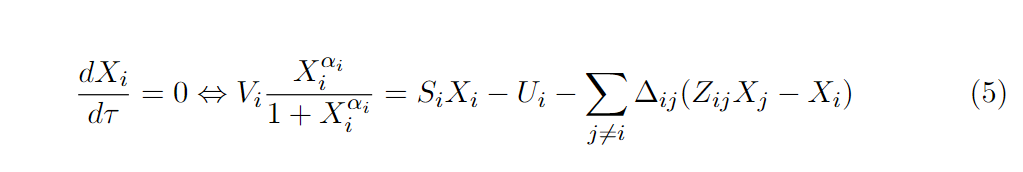

In [3]:
# Interactive plot
def plot_curves(V, alpha, S, U, delta, Z, Xj):
  def internal_release(x, V, alpha):
    return V * (x ** alpha / (1 + (x ** alpha)))

  def with_dispersion(x, S, U, delta, Z, Xj):
      return S * x - U - delta * (Z * Xj - x)

  def without_dispersion(x, S, U):
      return S * x - U

  # Generate x values
  x_values = np.linspace(0, 3, 200)

  plt.figure(figsize=(6,6))
  # Plot the curves
  plt.plot(x_values, internal_release(x_values, V, alpha), label='Internal release', color='green')
  plt.plot(x_values, with_dispersion(x_values, S, U, delta, Z, Xj), label=f'Net flow with dispersion. Xj = {Xj}', color='orange')
  plt.plot(x_values, without_dispersion(x_values, S, U), label='Net flow without dispersion', color='blue')

  # Add labels and legend
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.legend()

  # Show the plot
  plt.show()

# Define and initialize
V = 5
alpha = 5
S = 0.9
U = 0.2
delta = 0.5
Z = 0.6
Xj = 0.1

# Create sliders
interactive(
    plot_curves,
    V=FloatSlider(min=0, max=5.0, step=0.1, value=V), alpha=FloatSlider(min=2, max=10.0, step=1, value=alpha),
    S=FloatSlider(min=0, max=1.0, step=0.01, value=S), U=FloatSlider(min=0, max=2.0, step=0.1, value=U),
    delta=FloatSlider(min=0, max=2.0, step=0.05, value=delta), Z=FloatSlider(min=0, max=2.0, step=0.05, value=Z),
    Xj=FloatSlider(min=0, max=4.0, step=0.1, value=Xj)
)

interactive(children=(FloatSlider(value=5.0, description='V', max=5.0), FloatSlider(value=5.0, description='al…

I changed the steps of alpha: I think it makes the most sense to use steps of 1 for this one to not have exponents with decimals and the minimum should be 2 below that there is no real curvature and no potential regime shift.
s is a rate so it should be in the interval [0,1], I changed it and used steps of 0.01 instead of 0.1.
u is the human load of pollution. I think it makes sense to not have it above the total stock of pollution.
delta is also a rate so between 0 and 1 and I increase the number of steps slightly
Z is the pollution threshold in the other plot so it should be lower than the total stock x if we want something interesting where threshold can occur. I put the limits between 0 and 2.
Delta is the share of dispersion from a plot over the intrinsic growth rate. So if it is below 1 (our standard) that means that the species grows more than what comes out from the patch through dispersion. If it is larger than 1, that means that more flows out than the growth. Probably only values slightly above 1 are possible if at all.
For Xj I took the same limits as for xi.
I also changed most lower limits to 0 instead of 0.1, It could be tricky if that means dividing by 0 but I don't think it does in this equation and it allows us to test what happens when that parameter is 0 and therefore does not influence the system at all.
I increased the number of steps for x to 200 instead of 100 to get nicer figures in limit cases. I think it still is rather quick.

*For each parameter value we will want to test if changing the parameter value can trigger a regime shift (change how the topological representation of the system changes: is is gradual or are there bifurcations)*

For v for example, we can show when there's only 1 intersection point for low values. After a certain threshold, the green and blue curve intersect three times and for even higher values even the green and orange curves intersect. So there are several steps:
* starting from some initial parameter values, we want to identify these types of bifurcation points for each parameter. Using the same initial values as baseline and only varying one parameter at a time.
* Investigate how these bifurcations may change when varying another parameter at the same time, does the bifurcation come at lower values of the first parameter tested, or at higher values of or does it disappear?
I think it could be interesting to investigate some pairwise comparisons like this.





---




# ANIMATIONS (UPDATED)

### In this updated version, I have created a generic animation where you can choose which parameter to use as a frame. Use the dropdown widget below to choose the parameter you want to vary and the other parameters will be constant.

##### OLD NOTE ####
I have added the following code that generates an animated series of figures. As V varies from 0 to 6, the green curve changes its shape. We can see the effect on the points where this curve intersects with the other two. I have made V change every second (1000 miliseconds) but you can change the speed by inserting a different value in interval=1000.

This is very nice. I have adapted the x axis (0,4), the limits of V (0,3) and the speed of the animation (100 msec). It would be interesing to see these plots with all the different parameters.

In [4]:
# Define the mathematical functions
def internal_release(x, V, alpha):
    return V * (x ** alpha / (1 + x ** alpha))

def with_dispersion(x, S, U, delta, Z, Xj):
    return (S + delta) * x - U - delta * Z * Xj

def without_dispersion(x, S, U):
    return S * x - U

# Animation Class
class AnimationPlot:
    def __init__(self, x_values, parameters, frame_param, frame_values, interval=100):
        """
        Initialize the AnimationPlot.

        :param x_values: Array of x values for plotting.
        :param parameters: Dictionary of parameters.
        :param frame_param: The parameter to animate.
        :param frame_values: Iterable of values for the frame parameter.
        :param interval: Delay between frames in milliseconds.
        """
        self.x_values = x_values
        self.parameters = parameters.copy()  # Copy to prevent mutation
        self.frame_param = frame_param
        self.frame_values = frame_values
        self.interval = interval

        # Set up the figure and axis
        self.fig, self.ax = plt.subplots(figsize=(6, 6))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_title(f'Animated Plot with {self.frame_param} as Frame Variable')
        self.ax.grid(True)

        # Initialize the animation
        self.ani = FuncAnimation(
            self.fig,
            self.update_plot,
            frames=self.frame_values,
            init_func=self.init_plot,
            blit=False,
            interval=self.interval,
            repeat=True
        )

        # Prevent the figure from displaying automatically in the notebook
        plt.close(self.fig)

    def init_plot(self):
        """
        Initialize the plot with initial data.
        """
        # Compute initial Y-values based on the first frame value
        frame_value = self.frame_values[0]
        self.parameters[self.frame_param] = frame_value

        y1 = internal_release(self.x_values, self.parameters['V'], self.parameters['alpha'])
        y2 = with_dispersion(
            self.x_values,
            self.parameters['S'],
            self.parameters['U'],
            self.parameters['delta'],
            self.parameters['Z'],
            self.parameters['Xj']
        )
        y3 = without_dispersion(self.x_values, self.parameters['S'], self.parameters['U'])

        # Plot initial curves
        self.line1, = self.ax.plot(self.x_values, y1, label='Internal release', color='green')
        self.line2, = self.ax.plot(self.x_values, y2, label=f'Net flow with dispersion. Xj = {self.parameters["Xj"]}', color='orange')
        self.line3, = self.ax.plot(self.x_values, y3, label='Net flow without dispersion', color='blue')

        # Add legend
        self.ax.legend()

        # Add initial text annotation for the frame parameter
        self.text = self.ax.text(0.7, 0.9, f'{self.frame_param} = {frame_value:.2f}',
                                 transform=self.ax.transAxes, fontsize=12, verticalalignment='top')

        return self.line1, self.line2, self.line3, self.text

    def update_plot(self, frame_value):
        """
        Update the plot for each frame.

        :param frame_value: Current value of the frame parameter.
        """
        # Update the frame parameter
        self.parameters[self.frame_param] = frame_value

        # Compute new Y-values based on updated parameters
        y1 = internal_release(self.x_values, self.parameters['V'], self.parameters['alpha'])
        y2 = with_dispersion(
            self.x_values,
            self.parameters['S'],
            self.parameters['U'],
            self.parameters['delta'],
            self.parameters['Z'],
            self.parameters['Xj']
        )
        y3 = without_dispersion(self.x_values, self.parameters['S'], self.parameters['U'])

        # Update the data of the plots
        self.line1.set_ydata(y1)
        self.line2.set_ydata(y2)
        self.line3.set_ydata(y3)

        # Update the text annotation
        self.text.set_text(f'{self.frame_param} = {frame_value:.2f}')

        return self.line1, self.line2, self.line3, self.text

    def get_animation_html(self):
        """
        Get the HTML representation of the animation.
        """
        return HTML(self.ani.to_html5_video())

    def save_animation(self, filename='animation.mp4', writer='ffmpeg'):
        """
        Save the animation to a file.

        :param filename: Name of the output file.
        :param writer: Writer to use ('ffmpeg', 'imagemagick', etc.).
        """
        self.ani.save(filename, writer=writer)
        print(f'Animation saved as {filename}')

# Function to create and return frame values based on the frame parameter
def get_frame_values(frame_param):
    """
    Get the range of values for the specified frame parameter.

    :param frame_param: The parameter to animate ('V', 'S', 'U', 'delta', 'Z', 'Xj', 'alpha').
    :return: Array of frame values.
    """
    parameter_ranges = {
        'V': np.arange(0, 3.1, 0.1),
        'S': np.arange(0.5, 1.5, 0.05),
        'U': np.arange(0.0, 0.5, 0.01),
        'delta': np.arange(0.1, 1.0, 0.05),
        'Z': np.arange(0.2, 1.2, 0.05),
        'Xj': np.arange(0.0, 0.5, 0.01),
        'alpha': np.arange(1, 10, 1)
    }

    if frame_param in parameter_ranges:
        return parameter_ranges[frame_param]
    else:
        # If no range is defined, use a default range
        return np.linspace(0, 3, 30)

# Function to create and return fixed parameters based on the frame parameter
def get_fixed_parameters(frame_param):
    """
    Get the fixed parameters, keeping the frame parameter variable.

    :param frame_param: The parameter to animate ('V', 'S', 'U', 'delta', 'Z', 'Xj', 'alpha').
    :return: Dictionary of fixed parameters.
    """
    fixed_parameters = {
        'V': 1.0,
        'alpha': 5,
        'S': 0.9,
        'U': 0.2,
        'delta': 0.5,
        'Z': 0.6,
        'Xj': 0.1
    }
    return fixed_parameters

# Function to create and display the animation based on selected frame parameter
def create_generic_animation(frame_param, output_widget):
    """
    Create and display an animation with the specified frame parameter.

    :param frame_param: The parameter to animate ('V', 'S', 'U', 'delta', 'Z', 'Xj', 'alpha').
    :param output_widget: The ipywidgets.Output() widget to display the animation.
    """
    with output_widget:
        # Clear previous output
        output_widget.clear_output(wait=True)

        # Close all existing figures to prevent memory leaks and unwanted displays
        plt.close('all')

        # Define fixed parameters
        fixed_parameters = get_fixed_parameters(frame_param)

        # Define the ranges for each parameter
        frame_values = get_frame_values(frame_param)

        # Create x values
        x_values = np.linspace(0, 3, 200)

        # Initialize the AnimationPlot
        animation = AnimationPlot(
            x_values=x_values,
            parameters=fixed_parameters,
            frame_param=frame_param,
            frame_values=frame_values,
            interval=100  # milliseconds
        )

        # Display the animation
        display(animation.get_animation_html())

# Interactive Widget to Select Frame Parameter
frame_options = ['V', 'S', 'U', 'delta', 'Z', 'Xj', 'alpha']
dropdown = widgets.Dropdown(
    options=frame_options,
    value='V',
    description='Frame Param:',
    disabled=False,
)

# Create an Output widget to contain the animation
animation_output = widgets.Output()

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        # Create and display the new animation in the output widget
        create_generic_animation(change['new'], animation_output)

# Attach the callback to the dropdown
dropdown.observe(on_change)

# Display the dropdown and the output widget
display(dropdown, animation_output)

# Initialize the animation with the default dropdown value
create_generic_animation(dropdown.value, animation_output)


Dropdown(description='Frame Param:', options=('V', 'S', 'U', 'delta', 'Z', 'Xj', 'alpha'), value='V')

Output()

# Animation over combinations of V and S

Here V and S change and we can see the effects of different combinations of V and S. For each value of V, the blue line shifts based on S.

This is a nice animation too but it becomes hard to see exaclty what is happening. I guess potentially it could be interesting but that would require testing a whole bunch of different parameter values variations. I'm thinking it is maybe more useful to do proper testing with the animations for one parameter variation above. If we do such an animation for each parameter value it is still relatively easy to vary other parameter values in those animations by changing the other parameter values by hand. Perhaps we could get sliders for those too? Or will it become too computationally heavy?

In [5]:
# Function to update the plot with new parameters
def update_plot(frame):
    # Extract V and S from the grid
    V, S = grid[frame]

    alpha = 5
    U = 0.2
    delta = 0.5
    Z = 0.6
    Xj = 0.1

    # Clear previous plot
    plt.clf()

    # Plot the curves with new parameters
    plt.plot(x_values, internal_release(x_values, V, alpha), label='Internal release', color='green')
    plt.plot(x_values, with_dispersion(x_values, S, U, delta, Z, Xj), label=f'Net flow with dispersion. S = {S}', color='orange')
    plt.plot(x_values, without_dispersion(x_values, S, U), label='Net flow without dispersion', color='blue')

    # Add labels and legend
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

    # Add text annotation for V and S values
    plt.text(0.7, 0.9, f'V = {V:.2f}, S = {S:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Function to initialize the plot
def init():
    return

# Generate x values
x_values = np.linspace(0, 5, 200)

# Define the internal_release and other functions
def internal_release(x, V, alpha):
    return V * (x ** alpha / (1 + (x ** alpha)))

def with_dispersion(x, S, U, delta, Z, Xj):
    return S * x - U - delta * (Z * Xj - x)

def without_dispersion(x, S, U):
    return S * x - U

# Define the range of values for V and S
V_values = np.linspace(0, 5, 10)  # Example: 10 evenly spaced values from 0 to 5
S_values = np.linspace(0, 1, 5)   # Example: 5 evenly spaced values from 0 to 1

# Create a grid of V and S values
grid = np.array([(V, S) for V in V_values for S in S_values])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Set up the animation
ani = FuncAnimation(fig, update_plot, frames=len(grid), init_func=init, blit=False, interval=300)

# Display the animation
HTML(ani.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

## 3.1.1 Application to two plots, pollution model
### Equations 12 and 13
### Phase portrait


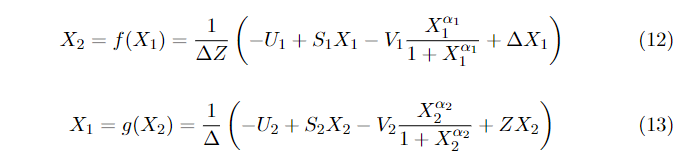

In [ ]:
# Function to generate the plot
def generate_plot(U1, V1, S1, U2, V2, S2, alpha1, alpha2, delta, Z):
    def fx(x1):
        return (1/(delta*Z)) * (-U1 + S1*x1 - V1*(x1**alpha1/(1+x1**alpha1)) + delta*x1)

    def gx(x2):
        return (1/delta) * (-U2 + S2*x2 - V2*(x2**alpha2/ (1+x2**alpha2)) + Z*x2)

    def dx1_dt(x1, x2):
        return -U1 - S1*x1 + V1*(x1**alpha1/(1+x1**alpha1)) + delta*(Z*x2 - x1)

    def dx2_dt(x1, x2):
        return -U2 - S2*x2 + V2*(x2**alpha2/ (1+x2**alpha2)) + delta*(x1 - Z*x2)

    # Solve for points where fx(x1) = 0
    roots_fx = fsolve(fx, [0, 1, 2])

    # Solve for points where gx(x2) = 0
    roots_gx = fsolve(gx, [0, 1, 2])

    # Set up a grid of points in the X1-X2 plane
    x1_vals, x2_vals = np.meshgrid(np.linspace(-1, 3, 20), np.linspace(-1, 3, 20))

    # Compute the derivatives at each point
    dx1_dt_vals = dx1_dt(x1_vals, x2_vals)
    dx2_dt_vals = dx2_dt(x1_vals, x2_vals)

    x_values = np.linspace(0, 3, 1000)
    plt.figure(figsize=(6, 6))

    # Plot the curves
    plt.plot(x_values, fx(x_values), label='Patch1', color='green')
    plt.plot(gx(x_values), x_values, label='Patch2', color='red')

   #Plot points where fx(x1) = 0 and gx(x2) = 0
   #plt.scatter(roots_fx, [0]*len(roots_fx), color='blue', marker='o', label='fx(x1) = 0')
   #plt.scatter([0]*len(roots_gx), roots_gx, color='orange', marker='o', label='gx(x2) = 0')

    # Add phase portrait vectors
    plt.quiver(x1_vals, x2_vals, dx1_dt_vals, dx2_dt_vals, scale=30, color='grey', width=0.0025, headwidth=3)

    # Add lines at X2=0 and X1=0
    # plt.axhline(0, color='black', linestyle='--', linewidth=1)
    # plt.axvline(0, color='black', linestyle='--', linewidth=1)

    # Add labels and legend
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim(0, 3)
    plt.ylim(0, 3)
    plt.legend()

    # Show the plot
    plt.show()

# Define and initialize parameters
U1 = 0.34
V1 = 0.8
S1 = 0.62
U2 = 0.21
V2 = 1.6
S2 = 0.83
alpha1 = 5
alpha2 = 5
delta = 0.15
Z = 0.33

# Create sliders
U1_slider = FloatSlider(value=0.34, min=0, max=5, step=0.01, description='U1:')
V1_slider = FloatSlider(value=0.8, min=0, max=5, step=0.1, description='V1:')
S1_slider = FloatSlider(value=0.62, min=0, max=1, step=0.01, description='S1:')
U2_slider = FloatSlider(value=0.21, min=0, max=5, step=0.01, description='U2:')
V2_slider = FloatSlider(value=1.6, min=0, max=5, step=0.1, description='V2:')
S2_slider = FloatSlider(value=0.83, min=0, max=1, step=0.01, description='S2:')
alpha1_slider = FloatSlider(value=5, min=2, max=10, step=1, description='alpha1:')
alpha2_slider = FloatSlider(value=5, min=2, max=10, step=1, description='alpha2:')
delta_slider = FloatSlider(value=0.15, min=0, max=2, step=0.01, description='delta:')
Z_slider = FloatSlider(value=0.33, min=0, max=2, step=0.01, description='Z:')

# Create interactive plot
interactive_plot = interactive(generate_plot, U1=U1_slider, V1=V1_slider, S1=S1_slider, U2=U2_slider,
                               V2=V2_slider, S2=S2_slider, alpha1=alpha1_slider,  alpha2=alpha2_slider, delta=delta_slider, Z=Z_slider)

# Display the interactive plot
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(FloatSlider(value=0.34, description='U1:', max=5.0, step=0.01), FloatSlider(value=0.8, dâ€¦

Here I just implemented the same thresholds and steps as in the previous figure. In this one again we want to investigate what changes in parameters can trigger a bifurcation. It would be nice to get the following:
* figures showing different possible numbers of intersection points between these two curves. I will try to find one set of parameter values that give many intersection points and we can have it as a baseline case, changing other parameter values from there to investigate when we get bifurcations. To do that I will have to check the calculations I made in the overleaf file about these threshold values so see if I can calculate some of those with the parameter values we have.
* figures showing the impact of varying each parameter value on the outcome. What are the threshold points for which we get a bifurcation?
* figures showing how these bifurcation points can be influenced bu changing other parameter values.

It turned out that it was easy to get bifurcation points just by varying Delta using the current parameter set up


In [ ]:
from ipywidgets import FloatSlider, interactive, VBox, HBox, Layout

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Function to calculate Jacobian matrix for stability analysis
def jacobian_matrix(x1, x2, U1, V1, S1, U2, V2, S2, alpha1, alpha2, delta, Z):
    """
    Calculate the Jacobian matrix of the system at a given point (x1, x2).

    Parameters:
    - x1, x2: State variables
    - U1, V1, S1, U2, V2, S2, alpha1, alpha2, delta, Z: System parameters

    Returns:
    - jacobian: 2x2 NumPy array representing the Jacobian matrix
    """
    # Prevent division by zero
    if delta * Z == 0:
        dfx_dx1 = np.inf
    else:
        dfx_dx1 = (S1 - V1 * alpha1 * (x1 ** (alpha1 - 1)) / ((1 + x1 ** alpha1) ** 2)) / (delta * Z) + 1

    dfx_dx2 = -1
    dgx_dx1 = -1

    if delta == 0:
        dgx_dx2 = np.inf
    else:
        dgx_dx2 = (S2 - V2 * alpha2 * (x2 ** (alpha2 - 1)) / ((1 + x2 ** alpha2) ** 2)) / delta + Z

    # Handle potential divide by zero by assigning a large finite number instead of inf
    dfx_dx1 = dfx_dx1 if np.isfinite(dfx_dx1) else 1e10
    dgx_dx2 = dgx_dx2 if np.isfinite(dgx_dx2) else 1e10

    # Construct the Jacobian matrix
    jacobian = np.array([[dfx_dx1, dfx_dx2],
                         [dgx_dx1, dgx_dx2]])
    return jacobian

# Function to solve the system of equations simultaneously
def solve_equilibrium(U1, V1, S1, U2, V2, S2, alpha1, alpha2, delta, Z):
    """
    Solve for equilibrium points where dx1/dt = 0 and dx2/dt = 0.

    Parameters:
    - U1, V1, S1, U2, V2, S2, alpha1, alpha2, delta, Z: System parameters

    Returns:
    - solution: Tuple containing equilibrium values (x1, x2)
    """
    # Define the system of equations
    def equations(p):
        x1, x2 = p
        # To prevent invalid operations, ensure x1 and x2 are positive
        if x1 < 0 or x2 < 0:
            return (np.nan, np.nan)
        try:
            fx = (1 / (delta * Z)) * (-U1 + S1 * x1 - V1 * (x1 ** alpha1 / (1 + x1 ** alpha1)) + delta * x1)
            gx = (1 / delta) * (-U2 + S2 * x2 - V2 * (x2 ** alpha2 / (1 + x2 ** alpha2)) + Z * x2)
        except ZeroDivisionError:
            return (np.nan, np.nan)
        return (fx, gx)

    # Initial guesses: positive values to ensure valid solutions
    x_guess = [0.5, 0.5]

    # Use fsolve to solve the system
    solution, infodict, ier, mesg = fsolve(equations, x_guess, full_output=True)

    # Check if the solution converged and is valid
    if ier == 1 and all(np.isfinite(solution)) and all(solution >= 0):
        return solution
    else:
        # If fsolve didn't converge or found negative solutions, return NaNs
        return [np.nan, np.nan]

# Function to solve for all equilibrium points using multiple initial guesses
def solve_all_equilibria(U1, V1, S1, U2, V2, S2, alpha1, alpha2, delta, Z):
    """
    Solve for all equilibrium points by using multiple initial guesses.

    Returns:
    - equilibria: List of tuples containing equilibrium points (x1, x2)
    """
    initial_guesses = [
        [0.5, 0.5],
        [1.5, 1.5],
        [2.5, 2.5],
        [0.5, 2.5],
        [2.5, 0.5]
    ]
    equilibria = []
    for guess in initial_guesses:
        eq = solve_equilibrium(U1, V1, S1, U2, V2, S2, alpha1, alpha2, delta, Z)
        if not (np.isnan(eq[0]) or np.isnan(eq[1])) and eq not in equilibria:
            equilibria.append(eq)
    return equilibria

# Function to generate the plot
def generate_plot(U1, V1, S1, U2, V2, S2, alpha1, alpha2, delta, Z):
    """
    Generate the phase portrait with nullclines, equilibrium points, phase vectors, and stability analysis.

    Parameters:
    - U1, V1, S1, U2, V2, S2, alpha1, alpha2, delta, Z: System parameters
    """
    # Solve for all equilibrium points
    equilibrium_points = solve_all_equilibria(U1, V1, S1, U2, V2, S2, alpha1, alpha2, delta, Z)

    # Define the nullclines
    def fx(x1):
        # Avoid division by zero and invalid operations
        with np.errstate(divide='ignore', invalid='ignore'):
            return (1 / (delta * Z)) * (-U1 + S1 * x1 - V1 * (x1 ** alpha1 / (1 + x1 ** alpha1)) + delta * x1)

    def gx(x2):
        # Avoid division by zero and invalid operations
        with np.errstate(divide='ignore', invalid='ignore'):
            return (1 / delta) * (-U2 + S2 * x2 - V2 * (x2 ** alpha2 / (1 + x2 ** alpha2)) + Z * x2)

    # Define the derivatives for phase portrait
    def dx1_dt(x1, x2):
        # Avoid invalid operations
        with np.errstate(divide='ignore', invalid='ignore'):
            return -U1 - S1 * x1 + V1 * (x1 ** alpha1 / (1 + x1 ** alpha1)) + delta * (Z * x2 - x1)

    def dx2_dt(x1, x2):
        # Avoid invalid operations
        with np.errstate(divide='ignore', invalid='ignore'):
            return -U2 - S2 * x2 + V2 * (x2 ** alpha2 / (1 + x2 ** alpha2)) + delta * (x1 - Z * x2)

    # Set up a coarser grid to reduce the number of arrows
    grid_points = 20  # Reduced from 50 to 20 for better readability
    x1_vals, x2_vals = np.meshgrid(np.linspace(0, 3, grid_points), np.linspace(0, 3, grid_points))

    # Compute the derivatives at each grid point
    dx1_dt_vals = dx1_dt(x1_vals, x2_vals)
    dx2_dt_vals = dx2_dt(x1_vals, x2_vals)

    # Compute the magnitude of each vector for color mapping
    magnitude = np.sqrt(dx1_dt_vals**2 + dx2_dt_vals**2)

    # Avoid division by zero in magnitude
    magnitude[magnitude == 0] = 1

    # Normalize the vectors for uniform arrow lengths
    dx1_dt_normalized = dx1_dt_vals / magnitude
    dx2_dt_normalized = dx2_dt_vals / magnitude

    # Define the range for plotting nullclines
    x_values = np.linspace(0, 3, 1000)

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot the nullclines
    plt.plot(x_values, fx(x_values), label='Nullcline fx(x1)=0', color='green')
    plt.plot(gx(x_values), x_values, label='Nullcline gx(x2)=0', color='red')

    # Plot equilibrium points
    for point in equilibrium_points:
        plt.scatter(point[0], point[1], color='blue', marker='o', label='Equilibrium Point')

    # Add phase portrait vectors with color mapping based on magnitude
    quiver = plt.quiver(x1_vals, x2_vals, dx1_dt_normalized, dx2_dt_normalized,
                       magnitude,
                       scale=20,          # Adjusted scale for shorter arrows
                       cmap='viridis',    # Color map to represent magnitude
                       width=0.003,
                       headwidth=3,
                       alpha=0.6)          # Added transparency

    # Add colorbar to indicate vector magnitude
    plt.colorbar(quiver, label='Vector Magnitude')

    # Add reference lines at X2=0 and X1=0
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)

    # Add labels and legend
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim(0, 3)
    plt.ylim(0, 3)
    plt.legend()

    # Jacobian and Stability Analysis
    for (x1, x2) in equilibrium_points:
        jacobian = jacobian_matrix(x1, x2, U1, V1, S1, U2, V2, S2, alpha1, alpha2, delta, Z)
        try:
            eigenvalues = np.linalg.eigvals(jacobian)
            if np.all(eigenvalues.real < 0):
                stability = 'Stable'
                color = 'green'
                marker = 'o'
            elif np.any(eigenvalues.real > 0) and np.any(eigenvalues.real < 0):
                stability = 'Saddle'
                color = 'yellow'
                marker = 'D'
            else:
                stability = 'Unstable'
                color = 'red'
                marker = 'X'
            plt.scatter(x1, x2, color=color, marker=marker, label=f'{stability} Point')
            plt.text(x1, x2, f'{stability}', fontsize=10, ha='center', va='center', color='black')
        except np.linalg.LinAlgError:
            plt.text(x1, x2, 'Indeterminate', fontsize=10, ha='center', va='center', color='purple')

    # Show the plot
    plt.title('Phase Portrait with Stability Analysis')
    plt.grid(True)
    plt.show()

# Define and initialize parameters
U1 = 0.2
V1 = 2
S1 = 0.9
U2 = 0.3
V2 = 3
S2 = 0.95
alpha1 = 5
alpha2 = 5
delta = 0.9
Z = 0.6

# Create sliders with restricted ranges to prevent division by zero and invalid operations
sliders = [
    FloatSlider(value=U1, min=0, max=5, step=0.01, description='U1:', layout=Layout(width='300px')),
    FloatSlider(value=V1, min=0, max=5, step=0.1, description='V1:', layout=Layout(width='300px')),
    FloatSlider(value=S1, min=0, max=1, step=0.01, description='S1:', layout=Layout(width='300px')),
    FloatSlider(value=U2, min=0, max=5, step=0.01, description='U2:', layout=Layout(width='300px')),
    FloatSlider(value=V2, min=0, max=5, step=0.1, description='V2:', layout=Layout(width='300px')),
    FloatSlider(value=S2, min=0, max=1, step=0.01, description='S2:', layout=Layout(width='300px')),
    FloatSlider(value=alpha1, min=2, max=10, step=1, description='alpha1:', layout=Layout(width='300px')),
    FloatSlider(value=alpha2, min=2, max=10, step=1, description='alpha2:', layout=Layout(width='300px')),
    FloatSlider(value=delta, min=0.01, max=1, step=0.01, description='delta:', layout=Layout(width='300px')),
    FloatSlider(value=Z, min=0.01, max=2, step=0.01, description='Z:', layout=Layout(width='300px')),
]

# Define a layout with a red border and some padding
slider_container_layout = Layout(
    border='2px solid #01C159',
    padding='10px',
    border_radius='5px',
    margin='10px',
    width='60%'
)

# Split the sliders into two columns
sliders_per_column = len(sliders) // 2
sliders_column1 = sliders[:sliders_per_column]
sliders_column2 = sliders[sliders_per_column:]

# Create VBox for each column
column1 = VBox(sliders_column1, layout=Layout(margin='10px'))
column2 = VBox(sliders_column2, layout=Layout(margin='10px'))

# Create HBox to arrange columns horizontally
columns = HBox([column1, column2], layout=Layout(justify_content='space-between'))

# Create a VBox container for the columns with the red border layout
sliders_container = VBox([columns], layout=slider_container_layout)

# Create interactive plot
interactive_plot = interactive(
    generate_plot,
    U1=sliders[0],
    V1=sliders[1],
    S1=sliders[2],
    U2=sliders[3],
    V2=sliders[4],
    S2=sliders[5],
    alpha1=sliders[6],
    alpha2=sliders[7],
    delta=sliders[8],
    Z=sliders[9]
)

# Combine sliders and plot in a vertical layout
final_layout = VBox([
    sliders_container,
    interactive_plot.children[-1]  # The output area with the plot
])

# Display the complete interactive interface
display(final_layout)

## 3.2 Cascading shifts between resource systems
### Equations 25 and 26

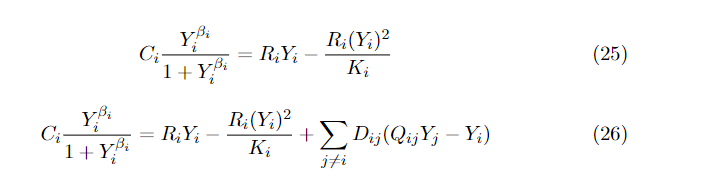

In [ ]:
# Function to generate the plot
def generate_plot(R, K, C, beta, D, Dij):
  def predation(y):
    return (C * y**beta) / (1 + y**beta)

  def growth_without(y):
    return R*y - (R * y**2) / K

  def growth_with(y, Dij, D):
    return R*y - (R * y**2) / K + (D - Dij*y)

  plt.figure(figsize=(12, 10))
  plt.title("Potential equilibria in resource system")
  plt.xlabel("y")
  plt.ylabel("dY/dT")
  plt.xlim(0, 10)
  plt.ylim(0, 3)

  x_values = np.linspace(0, 20, 1000)

  plt.plot(x_values, predation(x_values), label="Predation", color="darkgreen", linewidth=3)
  plt.plot(x_values, growth_without(x_values), label="Growth without dispersion", color="blue", linewidth=3)
  plt.plot(x_values, growth_with(x_values, Dij, D), label=f"Growth with dispersion (D={D}, Dij={Dij})", linewidth=2, color="darkorange")

  plt.legend()
  plt.show()

# Create sliders

R = 0.5
K = 10
C = 0.9
beta = 5
D = 0.02
Dij = 0.06


R_slider = FloatSlider(value=0.5, min=0, max=1, step=0.01, description='R:')
K_slider = FloatSlider(value=10, min=1, max=20, step=0.1, description='K:')
C_slider = FloatSlider(value=0.9, min=0, max=3, step=0.01, description='C:')
beta_slider = FloatSlider(value=5, min=1, max=10, step=1, description='beta:')
D_slider = FloatSlider(value=0.02, min=0, max=20, step=0.01, description='D:')
Dij_slider = FloatSlider(value=0.06, min=0, max=2, step=0.01, description='Dij:')

# Create interactive plot
interactive_plot = interactive(generate_plot, R=R_slider, K=K_slider, C=C_slider, beta=beta_slider, D=D_slider, Dij=Dij_slider)

# Display the interactive plot
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='R:', max=1.0, step=0.01), FloatSlider(value=10.0, deâ€¦

D=sum DijQijYj and is taken as constant here, which is why Q doesn't enter the formula.Also it is not a rate it is the totalamount of the stock that leaves plot 1 to move to plot j. So the upper limit could be as high as the upper limit for the stock. I'm not sure it makes entire sense but it could in any case be above 1. I adjusted that.
I think it would be good to limit the scale of the vertical axis to 2 or 3 maybe but I don't know how to do that.
My original figures are wrong but it seems that most of the results remain.


# 3.2.1 Application to two plots, resource model
## Equations 33 and 34


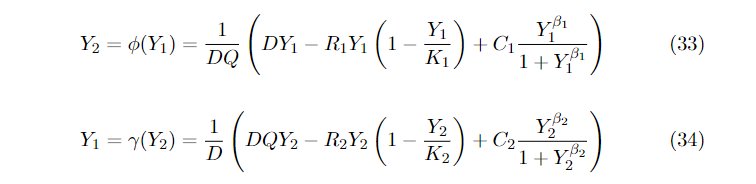

In [ ]:
# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Define the system of equations
def system(y, C1, R1, K1, C2, R2, K2, beta1, beta2, delta, Q):
    y1, y2 = y
    dy1_dt = R1*y1*(1 - y1/K1) - C1*(y1**beta1)/(1 + y1**beta1) + delta*(Q*y2 - y1)
    dy2_dt = R2*y2*(1 - y2/K2) - C2*(y2**beta2)/(1 + y2**beta2) + delta*(y1 - Q*y2)
    return [dy1_dt, dy2_dt]

# Define the Jacobian matrix
def jacobian_matrix(y1, y2, C1, R1, K1, C2, R2, K2, beta1, beta2, delta, Q):
    # Partial derivatives
    df_dy1 = R1*(1 - y1/K1) - (R1*y1)/K1 - (C1 * beta1 * y1**(beta1 - 1)) / ((1 + y1**beta1)**2) - delta
    df_dy2 = delta * Q

    dg_dy1 = delta
    dg_dy2 = R2*(1 - y2/K2) - (R2*y2)/K2 - (C2 * beta2 * y2**(beta2 -1)) / ((1 + y2**beta2)**2) - delta*Q

    jacobian = np.array([[df_dy1, df_dy2],
                         [dg_dy1, dg_dy2]])
    return jacobian

# Function to solve for all equilibrium points using multiple initial guesses
def solve_all_equilibria(C1, R1, K1, C2, R2, K2, beta1, beta2, delta, Q):
    initial_guesses = [
        [0.5, 0.5],
        [5, 5],
        [10, 10],
        [0.5, 10],
        [10, 0.5],
        [3, 7],
        [7, 3]
    ]
    equilibria = []
    for guess in initial_guesses:
        sol, infodict, ier, mesg = fsolve(system, guess, args=(C1, R1, K1, C2, R2, K2, beta1, beta2, delta, Q), full_output=True)
        if ier == 1 and all(sol >=0) and not any(np.isnan(sol)):
            sol = tuple(np.round(sol, 4))
            if sol not in equilibria:
                equilibria.append(sol)
    return equilibria

# Function to generate the plot
def generate_plot(C1, R1, K1, C2, R2, K2, beta1, beta2, delta, Q):
    """
    Generate the phase portrait with nullclines, equilibrium points, phase vectors, and stability analysis.

    Parameters:
    - C1, R1, K1, C2, R2, K2, beta1, beta2, delta, Q: System parameters
    """
    def fy(y1):
        return (1/(delta*Q)) * (delta*y1 - R1*y1 *(1 - y1/K1) + C1*(y1**beta1)/(1 + y1**beta1))

    def gy(y2):
        return (1/delta) * (delta*Q*y2 - R2*y2*(1 - y2/K2) + C2*(y2**beta2)/(1 + y2**beta2))

    # Set up a coarser grid to reduce the number of arrows
    grid_points = 20  # Reduced from 50 to 20 for better readability
    y1_vals, y2_vals = np.meshgrid(np.linspace(0, 12, grid_points), np.linspace(0, 12, grid_points))

    # Compute the derivatives at each grid point
    dy1_dt_vals = R1*y1_vals*(1 - y1_vals/K1) - C1*(y1_vals**beta1)/(1 + y1_vals**beta1) + delta*(Q*y2_vals - y1_vals)
    dy2_dt_vals = R2*y2_vals*(1 - y2_vals/K2) - C2*(y2_vals**beta2)/(1 + y2_vals**beta2) + delta*(y1_vals - Q*y2_vals)

    y_values = np.linspace(0, 15, 1000)
    plt.figure(figsize=(8, 8))

    # Plot the nullclines
    plt.plot(y_values, fy(y_values), label='fy(y1)=0', color='green')
    plt.plot(gy(y_values), y_values, label='gy(y2)=0', color='red')

    # Add phase portrait vectors with improved readability
    # Compute the magnitude of each vector for color mapping
    magnitude = np.sqrt(dy1_dt_vals**2 + dy2_dt_vals**2)
    magnitude[magnitude == 0] = 1  # Prevent division by zero

    # Normalize the vectors for uniform arrow lengths
    dy1_dt_normalized = dy1_dt_vals / magnitude
    dy2_dt_normalized = dy2_dt_vals / magnitude

    # Plot the vector field
    quiver = plt.quiver(y1_vals, y2_vals, dy1_dt_normalized, dy2_dt_normalized,
                       magnitude,
                       scale=30,
                       cmap='viridis',
                       width=0.0025,
                       headwidth=3,
                       alpha=0.6)

    # Add colorbar to indicate vector magnitude
    plt.colorbar(quiver, label='Vector Magnitude')

    # Add lines at Y2=0 and Y1=0
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)

    # Add labels and legend
    plt.xlabel('Y1')
    plt.ylabel('Y2')
    plt.xlim(0, 12.5)
    plt.ylim(0, 12.5)
    plt.legend()

    # Stability Analysis
    equilibria = solve_all_equilibria(C1, R1, K1, C2, R2, K2, beta1, beta2, delta, Q)
    for (y1, y2) in equilibria:
        jacobian = jacobian_matrix(y1, y2, C1, R1, K1, C2, R2, K2, beta1, beta2, delta, Q)
        try:
            eigenvalues = np.linalg.eigvals(jacobian)
            if np.all(eigenvalues.real < 0):
                stability = 'Stable'
                color = 'green'
                marker = 'o'
            elif np.any(eigenvalues.real > 0) and np.any(eigenvalues.real < 0):
                stability = 'Saddle'
                color = 'yellow'
                marker = 'D'
            else:
                stability = 'Unstable'
                color = 'red'
                marker = 'X'
            plt.scatter(y1, y2, color=color, marker=marker, label=f'{stability} Point')
            plt.text(y1, y2, f'{stability}', fontsize=10, ha='center', va='center', color='black')
        except np.linalg.LinAlgError:
            plt.text(y1, y2, 'Indeterminate', fontsize=10, ha='center', va='center', color='purple')

    # Show the plot
    plt.title('Phase Portrait with Nullclines, Vector Field, and Stability Analysis')
    plt.grid(True)
    plt.show()

# Create sliders

C1 = 1.9
R1 = 0.74
K1 = 13.3
C2 = 1.9
R2 = 0.74
K2 = 13.3
beta1 = 5
beta2 = 5
delta = 0.1
Q = 0.95

C1_slider = FloatSlider(value=C1, min=0, max=3, step=0.01, description='C1:', layout=Layout(width='300px'))
R1_slider = FloatSlider(value=R1, min=0, max=1, step=0.01, description='R1:', layout=Layout(width='300px'))
K1_slider = FloatSlider(value=K1, min=0, max=20, step=0.01, description='K1:', layout=Layout(width='300px'))
C2_slider = FloatSlider(value=C2, min=0, max=3, step=0.01, description='C2:', layout=Layout(width='300px'))
R2_slider = FloatSlider(value=R2, min=0, max=1, step=0.01, description='R2:', layout=Layout(width='300px'))
K2_slider = FloatSlider(value=K2, min=0, max=20, step=0.01, description='K2:', layout=Layout(width='300px'))
beta1_slider = FloatSlider(value=beta1, min=1, max=10, step=1, description='beta1:', layout=Layout(width='300px'))
beta2_slider = FloatSlider(value=beta2, min=1, max=10, step=1, description='beta2:', layout=Layout(width='300px'))
delta_slider = FloatSlider(value=delta, min=0, max=1, step=0.01, description='delta:', layout=Layout(width='300px'))
Q_slider = FloatSlider(value=Q, min=0, max=5, step=0.01, description='Q:', layout=Layout(width='300px'))

# Create sliders list
sliders = [
    C1_slider, R1_slider, K1_slider,
    C2_slider, R2_slider, K2_slider,
    beta1_slider, beta2_slider, delta_slider, Q_slider
]

# Define a layout with a red border
slider_container_layout = Layout(
    border='2px solid #01C159',
    padding='10px',
    border_radius='5px',
    margin='10px',
    width='60%')

# Split the sliders into two columns
sliders_per_column = len(sliders) // 2
sliders_column1 = sliders[:sliders_per_column]
sliders_column2 = sliders[sliders_per_column:]

# Create VBox for each column
column1 = VBox(sliders_column1, layout=Layout(margin='10px'))
column2 = VBox(sliders_column2, layout=Layout(margin='10px'))

# Create HBox to arrange columns horizontally
columns = HBox([column1, column2], layout=Layout(justify_content='space-between'))

# Create a VBox container for the columns with the red border layout
sliders_container = VBox([columns], layout=slider_container_layout)

# Create interactive plot
interactive_plot = interactive(generate_plot,
                               C1=C1_slider,
                               R1=R1_slider,
                               K1=K1_slider,
                               C2=C2_slider,
                               R2=R2_slider,
                               K2=K2_slider,
                               beta1=beta1_slider,
                               beta2=beta2_slider,
                               delta=delta_slider,
                               Q=Q_slider)

# Combine sliders and plot in a vertical layout
final_layout = VBox([
    sliders_container,
    interactive_plot.children[-1]  # The output area with the plot
])

# Display the complete interactive interface
display(final_layout)


I have verified the calculations in the overleaf file. They were accurate. I have also adapted the parameter values to get reasonable figures. Current parameter values give 9 intersection points. it is easy to vary some values to get 7, 5, 3 or only one intersection point.  
I haven't verified the location of the equilibria in the figures yet.

# 4. Controlling cascades


---



# 4.1. Controlling pollution cascades

## Equation 49

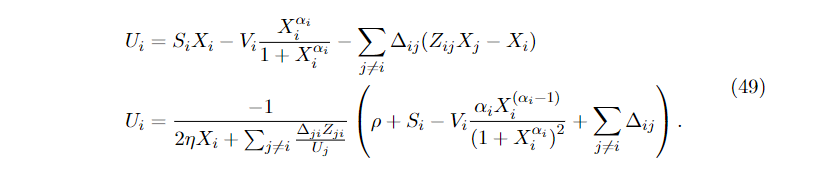

In [ ]:
# Function to generate the plot
def generate_plot(V, a, S, D, Z, Xj, Uj, r, n):
  def pollution_with_dispersion(x):
    return S*x - V * ((x**a)/(1+(x**a))) - D*(Z*Xj - x)

  def pollution_without_dispersion(x):
      return S*x - V * ((x**a)/(1+(x**a)))

  def control_with_dispersion(x):
      return (1/(2*n*x + (D*Z/Uj))) * ((r + S) - (V*(a*(x**(a-1))))/((1+(x**a))**2) + D)

  def control_without_dispersion(x):
      return (1/(2*n*x)) * ((r + S) - (V*(a*(x**(a-1))))/((1+(x**a))**2))

  plt.figure(figsize=(12, 10))
  plt.title("Phase diagram of the controlled pollution system")
  plt.xlabel("Xi")
  plt.ylabel("Ui")
  plt.xlim(-1, 3)
  plt.ylim(-1, 3)
  plt.gca().set_aspect('equal', adjustable='box')

  x_values = np.linspace(0, 3, 1000)

  plt.plot(x_values, pollution_with_dispersion(x_values), label="Pollution with dispersion", color="darkorange", linewidth=2)
  plt.plot(x_values, pollution_without_dispersion(x_values), label="Pollution without dispersion", color="blue", linewidth=2)
  plt.plot(x_values, control_with_dispersion(x_values), label="Control with dispersion", color="red", linewidth=2)
  plt.plot(x_values, control_without_dispersion(x_values), label="Control without dispersion", color="darkgreen", linewidth=2)
  plt.axhline(0, color='black', linestyle='--', linewidth=1)
  plt.axvline(0, color='black', linestyle='--', linewidth=1)
  plt.legend()
  plt.show()

# Create sliders

V = 1
a = 4
S = 0.65
D = 0.05
Z = 0.6
Xj = 0.4
Uj = 0.1
r = 0.03
n = 0.5


V_slider = FloatSlider(value=1, min=0, max=5, step=0.1, description='V:')
a_slider = FloatSlider(value=4, min=1, max=10, step=0.1, description='a:')
S_slider = FloatSlider(value=0.65, min=0, max=1, step=0.01, description='S:')
D_slider = FloatSlider(value=0.05, min=0, max=10, step=0.01, description='D:')
Z_slider = FloatSlider(value=0.6, min=0, max=1, step=0.01, description='Z:')
Xj_slider = FloatSlider(value=0.4, min=-1, max=1, step=0.01, description='Xj:')
Uj_slider = FloatSlider(value=0.1, min=0, max=1, step=0.01, description='Uj:')
r_slider = FloatSlider(value=0.03, min=0, max=1, step=0.01, description='r:')
n_slider = FloatSlider(value=0.5, min=0, max=1, step=0.01, description='n:')

# Create interactive plot
interactive_plot = interactive(generate_plot, V=V_slider, a=a_slider, S=S_slider, D=D_slider, Z=Z_slider, Xj=Xj_slider, Uj=Uj_slider, r=r_slider, n=n_slider)

# Display the interactive plot
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='V:', max=5.0), FloatSlider(value=4.0, description='aâ€¦

# 4.1.1. Two patches problem
## Equations 52 - 55

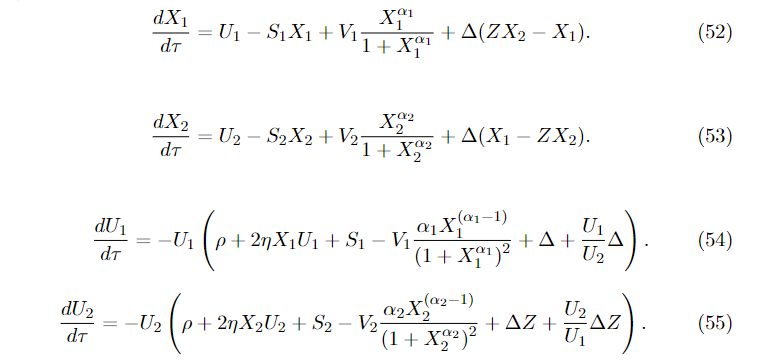

# 4.2. Controlling resource cascades

## Equation 67

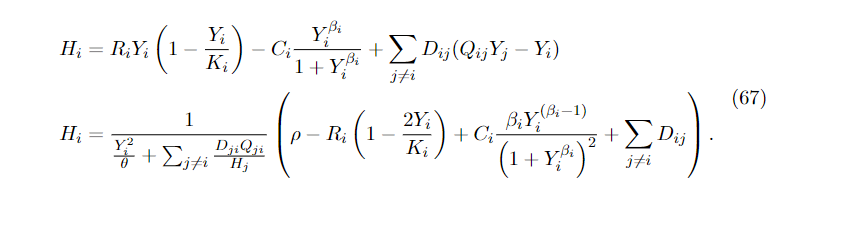

In [ ]:
# Function to generate the plot
def generate_plot(R, b, K, Zij, Dij, C, Yj, Hj, r, t):
  def resource_with_dispersion(y):
    return R*y - (1 - (y/K)) - (C * ((y**b) / (1 + (y**b)))) + (Dij * (Yj - y))

  def resource_without_dispersion(y):
      return R*y - (1 - (y/K)) - (C * ((y**b) / (1 + (y**b))))

  def harvest_with_dispersion(y):
      return (1 / (((y**2) / t) + (Dij / Hj))) * (r - (R * (1 - (2 * y/K))) + (C * (b * (y**(b-1)) / ((1 + (y**b))**2))) + Dij)

  def harvest_without_dispersion(y):
      return (1 / ((y**2) / t)) * (r - (R * (1 - (2 * y/K))) + (C * (b * (y**(b-1)) / ((1 + (y**b))**2))))

  plt.figure(figsize=(14, 10))
  plt.title("Phase diagrams of the controlled resource system")
  plt.xlabel("Yi")
  plt.ylabel("Hi")
  plt.xlim(0, 5)
  plt.ylim(-1, 1)

  x_values = np.linspace(0, 5, 1000)

  plt.plot(x_values, resource_with_dispersion(x_values), label="Resource with dispersion", color="darkorange", linewidth=3)
  plt.plot(x_values, resource_without_dispersion(x_values), label="Resource without dispersion", color="blue", linewidth=3)
  plt.plot(x_values, harvest_with_dispersion(x_values), label="Harvest with dispersion", color="red", linewidth=3)
  plt.plot(x_values, harvest_without_dispersion(x_values), label="Harvest without dispersion", color="darkgreen", linewidth=3)

  plt.legend()
  plt.show()

# Create sliders

R = 0.5
b = 4
K = 10
Zij = 1
Dij = 0.05
C = 0.5
Yj = 9
Hj = 5
r = 0.03
t = 0.1


R_slider = FloatSlider(value=0.5, min=0, max=1, step=0.01, description='R:')
b_slider = FloatSlider(value=4, min=1, max=10, step=0.1, description='b:')
K_slider = FloatSlider(value=10, min=1, max=20, step=0.1, description='K:')
Zij_slider = FloatSlider(value=1, min=0, max=5, step=0.1, description='Zij:')
Dij_slider = FloatSlider(value=0.05, min=0, max=1, step=0.01, description='Dij:')
C_slider = FloatSlider(value=0.5, min=0, max=1, step=0.01, description='C:')
Yj_slider = FloatSlider(value=9, min=0, max=15, step=0.1, description='Yj:')
Hj_slider = FloatSlider(value=5, min=1, max=10, step=0.1, description='Hj:')
r_slider = FloatSlider(value=0.03, min=0, max=1, step=0.01, description='r:')
t_slider = FloatSlider(value=0.1, min=0, max=1, step=0.01, description='t:')

# Create interactive plot
interactive_plot = interactive(generate_plot, R=R_slider, b=b_slider, K=K_slider, Zij=Zij_slider, Dij=Dij_slider, C=C_slider, Yj=Yj_slider, Hj=Hj_slider, r=r_slider, t=t_slider)

# Display the interactive plot
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='R:', max=1.0, step=0.01), FloatSlider(value=4.0, desâ€¦

# 4.2.1. Two patches problem

## Equations 70 - 73

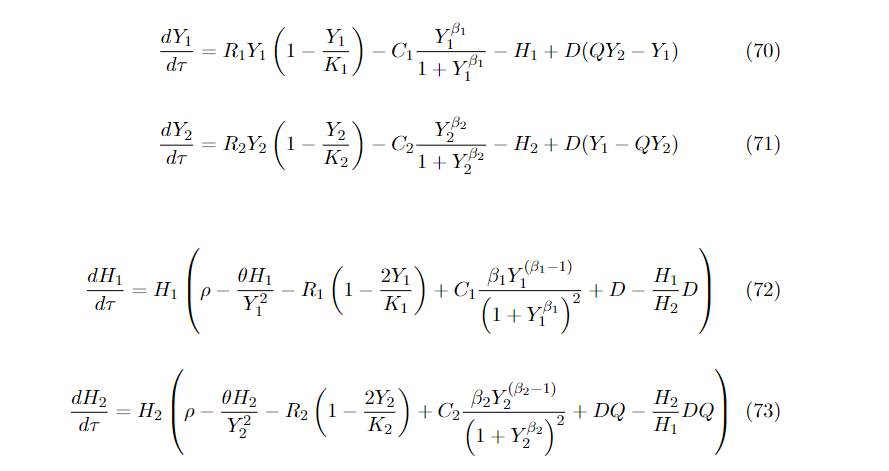